<a href="https://colab.research.google.com/github/tasty-orange/ARN-labs/blob/main/ARN_PW3_PT2_Piemontesi_Trueb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Partie 2



Epoch 1/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - AUC: 0.8856 - Precision: 0.8119 - Recall: 0.6625 - categorical_accuracy: 0.7632 - loss: 0.7056 - val_AUC: 0.9655 - val_Precision: 0.8884 - val_Recall: 0.8563 - val_categorical_accuracy: 0.8728 - val_loss: 0.4240
Epoch 2/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9605 - Precision: 0.8876 - Recall: 0.8558 - categorical_accuracy: 0.8728 - loss: 0.4415 - val_AUC: 0.9677 - val_Precision: 0.8887 - val_Recall: 0.8641 - val_categorical_accuracy: 0.8761 - val_loss: 0.3997
Epoch 3/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9643 - Precision: 0.8889 - Recall: 0.8614 - categorical_accuracy: 0.8753 - loss: 0.4127 - val_AUC: 0.9692 - val_Precision: 0.8909 - val_Recall: 0.8702 - val_categorical_accuracy: 0.8819 - val_loss: 0.3821
Epoch 4/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - AUC: 0.9662 - Precision: 0.8925 - Recall: 0.8685 - categorical_accuracy: 0.8811 - loss: 0.3928 - val_AUC: 0.9701 - val_Precision: 0.8914 - val_Reca

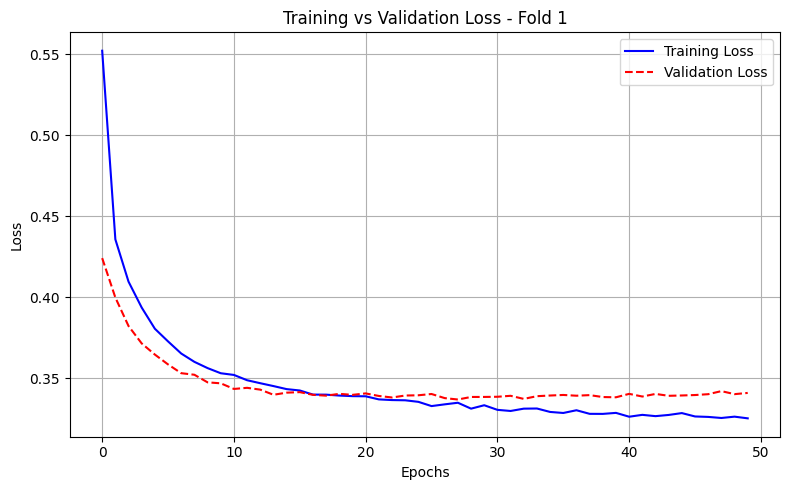

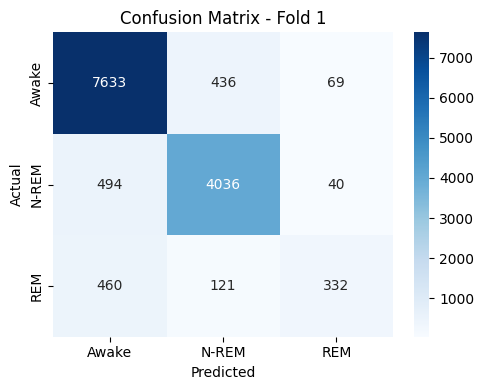

Epoch 1/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - AUC: 0.8802 - Precision: 0.7946 - Recall: 0.6464 - categorical_accuracy: 0.7480 - loss: 0.7103 - val_AUC: 0.9614 - val_Precision: 0.8820 - val_Recall: 0.8503 - val_categorical_accuracy: 0.8677 - val_loss: 0.4393
Epoch 2/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9590 - Precision: 0.8792 - Recall: 0.8465 - categorical_accuracy: 0.8641 - loss: 0.4496 - val_AUC: 0.9647 - val_Precision: 0.8850 - val_Recall: 0.8596 - val_categorical_accuracy: 0.8725 - val_loss: 0.4111
Epoch 3/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.9659 - Precision: 0.8868 - Recall: 0.8641 - categorical_accuracy: 0.8774 - loss: 0.4036 - val_AUC: 0.9657 - val_Precision: 0.8849 - val_Recall: 0.8647 - val_categorical_accuracy: 0.8755 - val_loss: 0.3962
Epoch 4/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9669 - Precision: 0.8870 - Recall: 0.8644 - categorical_accuracy: 0.8782 - loss: 0.3885 - val_AUC: 0.9663 - val_Precision: 0.8839 - val_Recal

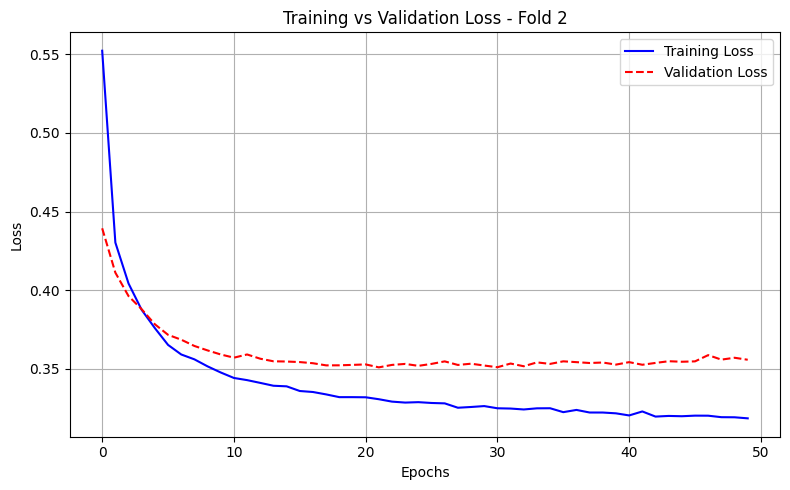

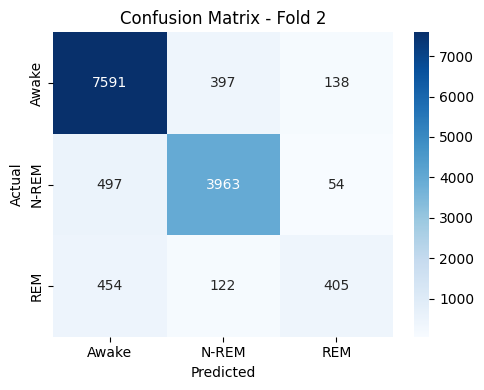

Epoch 1/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - AUC: 0.8776 - Precision: 0.8082 - Recall: 0.6429 - categorical_accuracy: 0.7450 - loss: 0.7033 - val_AUC: 0.9630 - val_Precision: 0.8891 - val_Recall: 0.8524 - val_categorical_accuracy: 0.8728 - val_loss: 0.4320
Epoch 2/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - AUC: 0.9595 - Precision: 0.8849 - Recall: 0.8447 - categorical_accuracy: 0.8670 - loss: 0.4474 - val_AUC: 0.9665 - val_Precision: 0.8901 - val_Recall: 0.8618 - val_categorical_accuracy: 0.8774 - val_loss: 0.4014
Epoch 3/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - AUC: 0.9626 - Precision: 0.8861 - Recall: 0.8572 - categorical_accuracy: 0.8728 - loss: 0.4204 - val_AUC: 0.9683 - val_Precision: 0.8914 - val_Recall: 0.8690 - val_categorical_accuracy: 0.8812 - val_loss: 0.3832
Epoch 4/50
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9660 - Precision: 0.8904 - Recall: 0.8649 - categorical_accuracy: 0.8780 - loss: 0.3939 - val_AUC: 0.9692 - val_Precision: 0.8918 - val_Recal

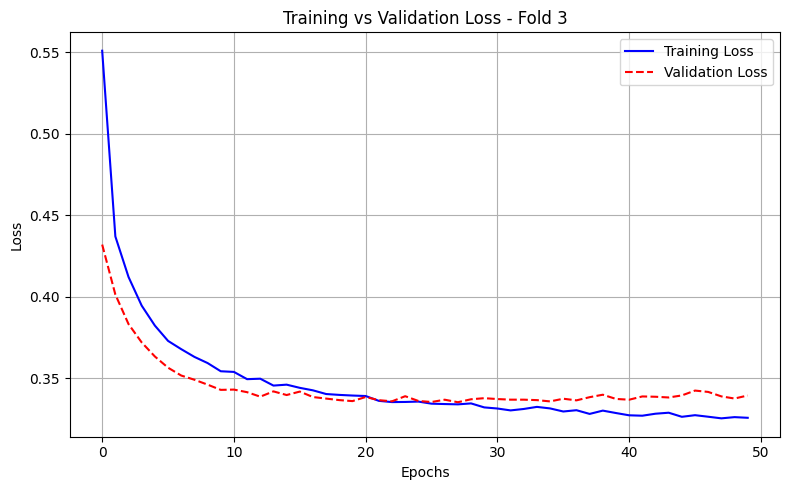

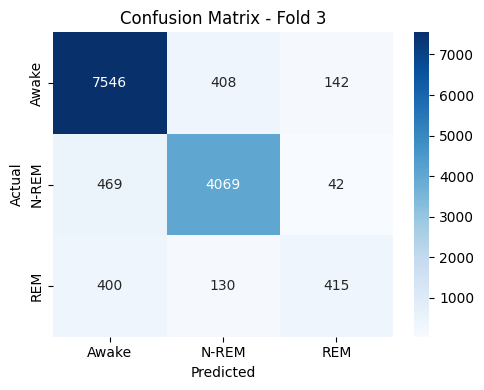


F1-score moyen final : 0.7696


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# Chargement des données
mice_eeg_1 = pd.read_csv('EEG_mouse_data_1.csv')
mice_eeg_2 = pd.read_csv('EEG_mouse_data_2.csv')
data_training = pd.concat([mice_eeg_1, mice_eeg_2])

# Chargement des données de test
data_test = pd.read_csv('EEG_mouse_data_test.csv')

# Normalisation des classes de la variable cible
data_training['state'] = data_training['state'].replace({'w': 'awake', 'n': 'n-rem', 'r': 'rem'})

# Séparer les caractéristiques et la variable cible
input_data = data_training.drop('state', axis=1).values
output_data = data_training['state'].values

# Garder seulement les 25 premières caractéristiques
input_data = input_data[:, :25]

# Normalisation des données
scaler = StandardScaler()
input_data = scaler.fit_transform(input_data)

# Encodage des labels (one-hot encoding)
encoder = LabelEncoder()
output_data = encoder.fit_transform(output_data)  # Convertir en 0, 1, 2
output_data = to_categorical(output_data, num_classes=3)  # Convertir en one-hot

# Définition du KFold
kf = KFold(n_splits=3, shuffle=True, random_state=1)

# Fonction pour créer le modèle
def create_model():
    model = Sequential([
        Input(shape=(25,)),

        # Première couche cachée
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

        # Deuxième couche cachée
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

        # Dropout
        Dropout(0.3),

        # Couche de sortie avec 3 neurones (une par classe) et softmax
        Dense(3, activation='softmax')
    ])

    # Compilation du modèle pour classification multi-classes
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005),  # Adam avec un LR plus bas pour plus de stabilité
        metrics=['categorical_accuracy', 'AUC', 'Precision', 'Recall']
    )


    return model

# Stockage des métriques
train_losses = []
val_losses = []
f1_scores = []
conf_matrices = []

# Entraînement avec validation croisée
for fold, (train_index, val_index) in enumerate(kf.split(input_data)):
    X_train, X_val = input_data[train_index], input_data[val_index]
    y_train, y_val = output_data[train_index], output_data[val_index]

    model = create_model()

    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

    # Stocker les pertes
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Prédictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir one-hot en labels
    y_true_classes = np.argmax(y_val, axis=1)  # Labels réels

    # Matrice de confusion
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    conf_matrices.append(cm)

    # Calcul du F1-score (macro)
    f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
    f1_scores.append(f1)

    # Affichage du F1-score
    print(f'F1-score pour le fold {fold+1}: {f1:.4f}')

    # Affichage du Loss pour le fold actuel
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses[fold], label='Training Loss', color='blue')
    plt.plot(val_losses[fold], label='Validation Loss', color='red', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training vs Validation Loss - Fold {fold+1}')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Affichage de la matrice de confusion pour ce fold
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrices[fold], annot=True, fmt='d', cmap='Blues', xticklabels=['Awake', 'N-REM', 'REM'], yticklabels=['Awake', 'N-REM', 'REM'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - Fold {fold+1}')
    plt.tight_layout()
    plt.show()

# Affichage du F1-score moyen final
mean_f1 = np.mean(f1_scores)
print(f'\nF1-score moyen final : {mean_f1:.4f}')
